# Citi Bike Data Exploration

Exploring 2013-2015 trip data (~23.5M trips)

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import folium
from folium.plugins import MarkerCluster

# Connect to DuckDB (in-memory, reads parquet files directly)
con = duckdb.connect()

# Path to parquet files
PARQUET_PATH = '../data/processed/*.parquet'

print('Connected to DuckDB')
print(f'Reading from: {PARQUET_PATH}')

Matplotlib is building the font cache; this may take a moment.


Connected to DuckDB
Reading from: ../data/processed/*.parquet


/Users/davidpiegaro/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 1. Basic Stats

In [2]:
# Overview stats
stats = con.execute(f'''
    SELECT 
        COUNT(*) as total_trips,
        COUNT(DISTINCT start_station_id) as unique_stations,
        MIN(started_at) as first_trip,
        MAX(started_at) as last_trip,
        ROUND(AVG(duration_sec)/60, 1) as avg_duration_min,
        ROUND(MEDIAN(duration_sec)/60, 1) as median_duration_min
    FROM "{PARQUET_PATH}"
''').fetchdf()

print("=== Dataset Overview ===")
for col in stats.columns:
    print(f"{col}: {stats[col][0]}")

=== Dataset Overview ===
total_trips: 23506787
unique_stations: 478
first_trip: 2013-06-01 00:00:01
last_trip: 2015-12-31 23:58:24
avg_duration_min: 14.0
median_duration_min: 10.6


## 2. Trips Over Time

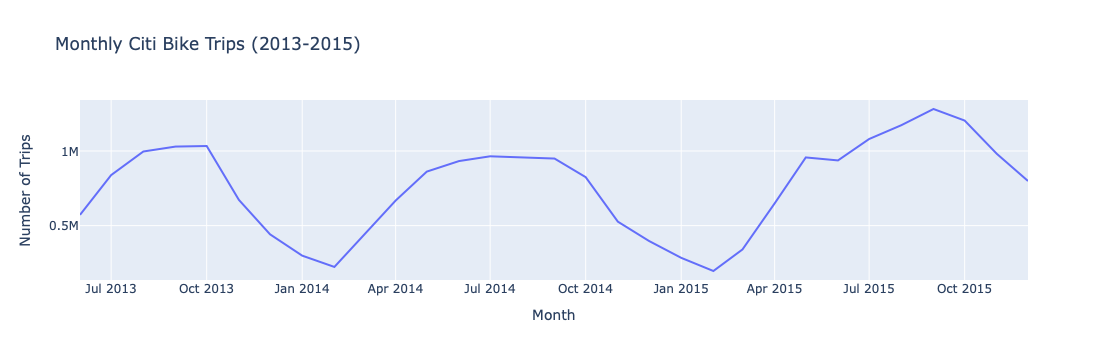

In [3]:
# Monthly trip counts
monthly = con.execute(f'''
    SELECT 
        DATE_TRUNC('month', started_at) as month,
        COUNT(*) as trips
    FROM "{PARQUET_PATH}"
    GROUP BY 1
    ORDER BY 1
''').fetchdf()

fig = px.line(monthly, x='month', y='trips', 
              title='Monthly Citi Bike Trips (2013-2015)',
              labels={'trips': 'Number of Trips', 'month': 'Month'})
fig.update_layout(hovermode='x unified')
fig.show()

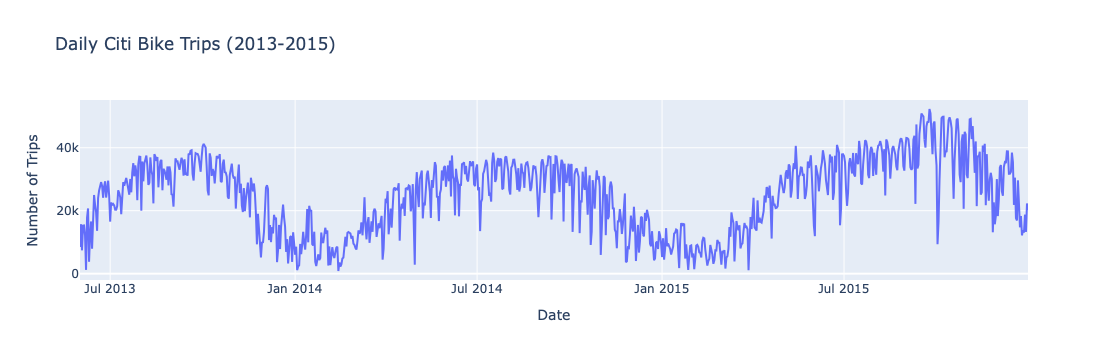

In [4]:
# Daily trip counts (shows seasonality)
daily = con.execute(f'''
    SELECT 
        DATE_TRUNC('day', started_at) as day,
        COUNT(*) as trips
    FROM "{PARQUET_PATH}"
    GROUP BY 1
    ORDER BY 1
''').fetchdf()

fig = px.line(daily, x='day', y='trips',
              title='Daily Citi Bike Trips (2013-2015)',
              labels={'trips': 'Number of Trips', 'day': 'Date'})
fig.show()

## 3. Trip Patterns by Hour & Day of Week

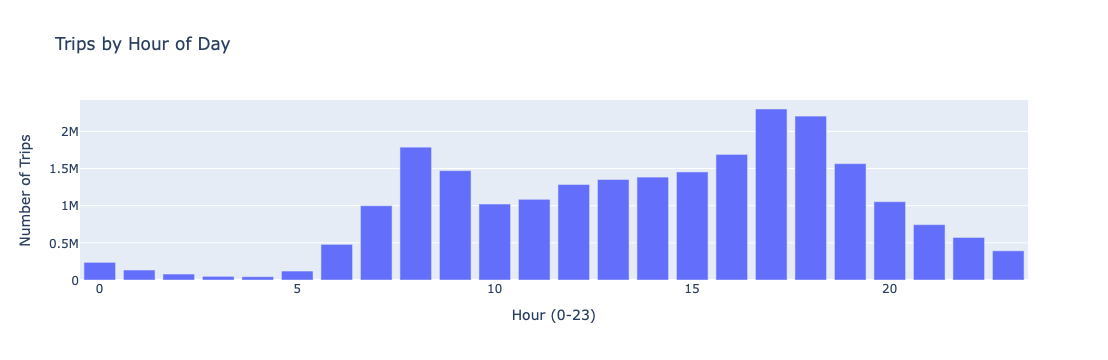

In [5]:
# Trips by hour of day
hourly = con.execute(f'''
    SELECT 
        EXTRACT(HOUR FROM started_at) as hour,
        COUNT(*) as trips
    FROM "{PARQUET_PATH}"
    GROUP BY 1
    ORDER BY 1
''').fetchdf()

fig = px.bar(hourly, x='hour', y='trips',
             title='Trips by Hour of Day',
             labels={'trips': 'Number of Trips', 'hour': 'Hour (0-23)'})
fig.show()

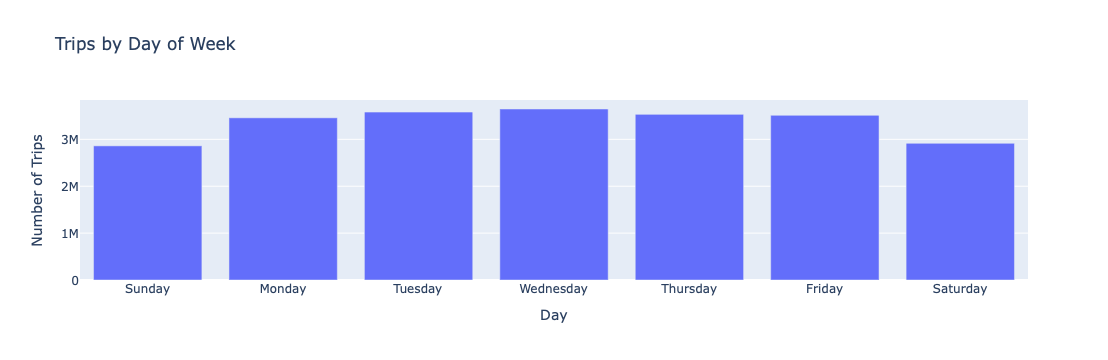

In [6]:
# Trips by day of week
dow = con.execute(f'''
    SELECT 
        DAYNAME(started_at) as day_name,
        DAYOFWEEK(started_at) as day_num,
        COUNT(*) as trips
    FROM "{PARQUET_PATH}"
    GROUP BY 1, 2
    ORDER BY 2
''').fetchdf()

fig = px.bar(dow, x='day_name', y='trips',
             title='Trips by Day of Week',
             labels={'trips': 'Number of Trips', 'day_name': 'Day'})
fig.show()

## 4. Station Expansion Map

Visualize how the station network grew from 2013 to 2015

In [7]:
# Get first appearance of each station
station_timeline = con.execute(f'''
    SELECT 
        start_station_id as station_id,
        start_station_name as station_name,
        start_lat as lat,
        start_lon as lon,
        MIN(started_at) as first_trip,
        YEAR(MIN(started_at)) as first_year,
        COUNT(*) as total_trips
    FROM "{PARQUET_PATH}"
    WHERE start_lat IS NOT NULL AND start_lon IS NOT NULL
    GROUP BY 1, 2, 3, 4
    ORDER BY first_trip
''').fetchdf()

print(f"Total unique stations: {len(station_timeline)}")
print(f"\nStations by first year:")
print(station_timeline.groupby('first_year').size())

Total unique stations: 478

Stations by first year:
first_year
2013    332
2015    146
dtype: int64


In [8]:
# Create map centered on NYC
nyc_center = [40.7128, -74.0060]
m = folium.Map(location=nyc_center, zoom_start=13, tiles='cartodbpositron')

# Color by year
colors = {2013: 'blue', 2014: 'green', 2015: 'red'}

for _, row in station_timeline.iterrows():
    color = colors.get(row['first_year'], 'gray')
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        popup=f"{row['station_name']}<br>First: {row['first_year']}<br>Trips: {row['total_trips']:,}",
        color=color,
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

# Add legend
legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; 
            background-color: white; padding: 10px; border-radius: 5px;
            border: 2px solid gray;">
    <p><strong>Station First Appearance</strong></p>
    <p><span style="color: blue;">●</span> 2013</p>
    <p><span style="color: green;">●</span> 2014</p>
    <p><span style="color: red;">●</span> 2015</p>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Display map
m

## 5. Top Stations

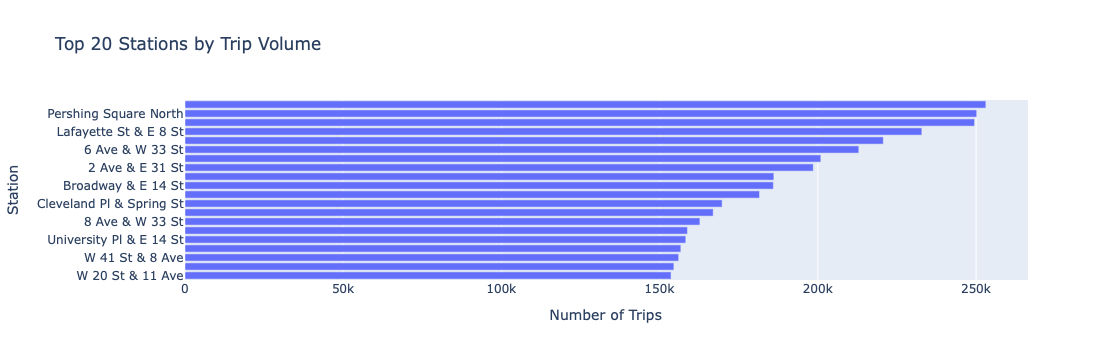

In [9]:
# Top 20 stations by trip volume
top_stations = con.execute(f'''
    SELECT 
        start_station_name as station,
        COUNT(*) as trips
    FROM "{PARQUET_PATH}"
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 20
''').fetchdf()

fig = px.bar(top_stations, x='trips', y='station', orientation='h',
             title='Top 20 Stations by Trip Volume',
             labels={'trips': 'Number of Trips', 'station': 'Station'})
fig.update_layout(yaxis={'categoryorder': 'total ascending'})
fig.show()

## 6. Member vs Casual Analysis

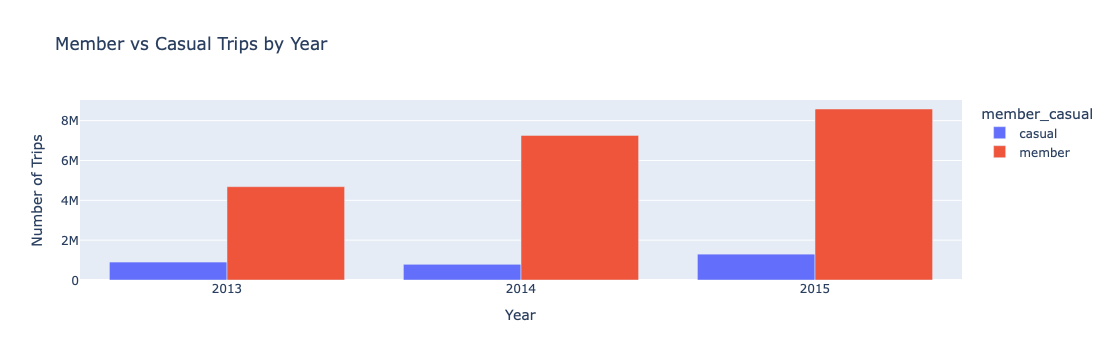

In [10]:
# Member vs casual by year
member_year = con.execute(f'''
    SELECT 
        YEAR(started_at) as year,
        member_casual,
        COUNT(*) as trips,
        ROUND(AVG(duration_sec)/60, 1) as avg_duration_min
    FROM "{PARQUET_PATH}"
    GROUP BY 1, 2
    ORDER BY 1, 2
''').fetchdf()

fig = px.bar(member_year, x='year', y='trips', color='member_casual',
             barmode='group',
             title='Member vs Casual Trips by Year',
             labels={'trips': 'Number of Trips', 'year': 'Year'})
fig.show()

In [ ]:
# Duration comparison
duration_comp = con.execute(f'''
    SELECT 
        member_casual,
        ROUND(AVG(duration_sec)/60, 1) as avg_min,
        ROUND(MEDIAN(duration_sec)/60, 1) as median_min,
        ROUND(PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY duration_sec)/60, 1) as p95_min
    FROM "{PARQUET_PATH}"
    GROUP BY 1
''').fetchdf()

print("Duration by User Type (minutes):")
print(duration_comp.to_string(index=False))

## 7. Custom Queries

Run your own SQL queries below!

In [ ]:
# Example: Your custom query here
result = con.execute(f'''
    SELECT 
        *
    FROM "{PARQUET_PATH}"
    LIMIT 5
''').fetchdf()

result